In [8]:
# 提取因子数据

#参数及工具函数部分
import pandas as pd
import numpy as np
from jqfactor import *
import warnings  
warnings.filterwarnings('ignore')

#获取数据主函数
#输入股票池、指标名称、开始日期、结束日期
#返回行标签为日期，列表签为股票名称的dataframe表格
def get_factor_data(stockPool, factor,date_start, date_end):
    
    #获取股票池函数
    def get_stock(stockPool, begin_date):
        if stockPool == 'HS300':#用于获取沪深300股票池
            stockList = get_index_stocks('000300.XSHG', begin_date)
        elif stockPool == 'ZZ500':#用于获取中证500股票池
            stockList = get_index_stocks('399905.XSHE', begin_date)
        elif stockPool == 'ZZ800':#用于获取中证800股票池
            stockList = get_index_stocks('399906.XSHE', begin_date)   
        elif stockPool == 'A':#用于获取全部A股股票池
            stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
        else:#自定义输入股票池
            stockList = stockPool
        return stockList    
    
    #从财务库获取数据
    def get_factor_account_data(factor,stock, date):
        if factor in val:
            q = query(valuation).filter(valuation.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in bal:
            q = query(balance).filter(balance.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in cf:
            q = query(cash_flow).filter(cash_flow.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in inc:
            q = query(income).filter(income.code.in_(stock))
            df = get_fundamentals(q, date)
        elif factor in ind:
            q = query(indicator).filter(indicator.code.in_(stock))
            df = get_fundamentals(q, date)

        df.index = df['code']
        data = pd.DataFrame(index = df.index)
        data[date] = df[factor]

        return data
    
    def get_trade_days(start_date = date_start, end_date = date_end):
    
        pool = get_index_stocks('000016.XSHG')

        date_list = get_price(pool,start_date=date_start,end_date=date_end,fields=['close'])['close'].index
        return date_list
    
    
    #获取日期列表
    date_list = get_trade_days(start_date = date_start, end_date = date_end)
    #空df预备存储数据，data_ret是返回数据
    data_ret = pd.DataFrame(data = [], columns = ['date','asset','factor'])
    
    #获取五张财务基础所有指标名称
    val = get_fundamentals(query(valuation).limit(1)).columns.tolist()
    bal = get_fundamentals(query(balance).limit(1)).columns.tolist()
    cf = get_fundamentals(query(cash_flow).limit(1)).columns.tolist()
    inc = get_fundamentals(query(income).limit(1)).columns.tolist()
    ind = get_fundamentals(query(indicator).limit(1)).columns.tolist()
    all_columns = val+bal+cf+inc+ind
    
    # 确定相应的股票池
    all_stocks = get_stock(stockPool, date_end)

    #循环时间列表获取指标数据
    for date in date_list:
        
        data_temp = pd.DataFrame(data = [],columns = ['date','asset','factor'])

        #获取股票池
        #获取因子数据
        if factor in all_columns: #可以从财务库直接取到因子值的因子
            data_temp['factor'] = get_factor_account_data(factor,all_stocks, date).iloc[:,0]
        
        # 暂时不支持因子库的算法，
        # 因为输出的格式暂不清楚
        
        # else: #可以从因子库直接取到因子值的因子
        #    try:
        #        data_temp['factor'] = get_factor_values(all_stocks, [factor], end_date = date, count = 1)[factor]
        #    except:
        #        print('系统暂不能获取该因子，请获取其他因子')
        #        break
                
        
        # 改造成alphalen需要格式
        # 确定资产名称
        data_temp['asset'] =  get_factor_account_data(factor,all_stocks, date).index
        
        # 确定日期
        data_temp['date'] =  np.array([date for i in range(0,data_temp.shape[0])])
        
        # 删除原先的索引
        data_temp = data_temp.reset_index()
        data_temp = data_temp.drop(['code'],axis=1)
        
        data_ret = pd.concat([data_ret, data_temp], axis = 0) 
        

        # 如果不需要则进行正常的数据合并
#         data = pd.concat([data, data_temp], axis = 0) 

    # 确定 multi_index
    data_ret = data_ret.set_index(['date','asset'])
    return data_ret



In [24]:
# 提取因子值，整合为alphalen需要的样式


# 示例，获取沪深300成分股在2019年前两个月的市盈率数据
# 注意：每次只能提取1个因子
factor_data = get_factor_data('HS300', 'pe_ratio','2016-1-10', '2017-1-10')
factor_data = factor_data.fillna(0)

In [33]:
# 提取价格数据

#获取股票池函数
def get_stock(stockPool, begin_date):
    if stockPool == 'HS300':#用于获取沪深300股票池
        stockList = get_index_stocks('000300.XSHG', begin_date)
    elif stockPool == 'ZZ500':#用于获取中证500股票池
        stockList = get_index_stocks('399905.XSHE', begin_date)
    elif stockPool == 'ZZ800':#用于获取中证800股票池
        stockList = get_index_stocks('399906.XSHE', begin_date)   
    elif stockPool == 'A':#用于获取全部A股股票池
        stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks('399107.XSHE', begin_date)
    else:#自定义输入股票池
        stockList = stockPool
    return stockList   


# 注意提取股票的时间，会导致股票池不同
# 股票池不同，会导致
all_stocks = get_stock('HS300', '2017-1-10')

price_data = get_price(all_stocks,start_date='2016-1-10',end_date='2018-8-10',fields=['close'])['close']
price_data

,000001.XSHE,000002.XSHE,000008.XSHE,000009.XSHE,000027.XSHE,000039.XSHE,000060.XSHE,000061.XSHE,000063.XSHE,000069.XSHE,000100.XSHE,000156.XSHE,000157.XSHE,000166.XSHE,000333.XSHE,000338.XSHE,000402.XSHE,000413.XSHE,000415.XSHE,000423.XSHE,000425.XSHE,000503.XSHE,000538.XSHE,000540.XSHE,000555.XSHE,000559.XSHE,000568.XSHE,000623.XSHE,000625.XSHE,000627.XSHE,000630.XSHE,000651.XSHE,000671.XSHE,000686.XSHE,000709.XSHE,000712.XSHE,000718.XSHE,000725.XSHE,000728.XSHE,000738.XSHE,...,601377.XSHG,601390.XSHG,601398.XSHG,601555.XSHG,601600.XSHG,601601.XSHG,601607.XSHG,601608.XSHG,601611.XSHG,601618.XSHG,601628.XSHG,601633.XSHG,601668.XSHG,601669.XSHG,601688.XSHG,601718.XSHG,601727.XSHG,601766.XSHG,601788.XSHG,601800.XSHG,601818.XSHG,601857.XSHG,601866.XSHG,601872.XSHG,601877.XSHG,601888.XSHG,601899.XSHG,601901.XSHG,601919.XSHG,601928.XSHG,601933.XSHG,601939.XSHG,601958.XSHG,601985.XSHG,601988.XSHG,601989.XSHG,601998.XSHG,603000.XSHG,603885.XSHG,603993.XSHG
2016-01-11,8.49,20.97,9.60,7.95,7.06,12.43,7.28,13.18,15.21,6.39,3.39,21.62,4.21,6.04,16.86,3.64,7.86,6.63,7.05,42.16,3.49,23.13,59.75,4.73,32.48,12.16,21.02,18.17,12.53,7.71,2.99,16.51,6.90,11.60,3.29,21.55,11.43,2.66,10.18,23.58,...,7.83,8.69,3.59,11.22,4.55,22.81,15.72,5.55,NaN,4.48,22.44,8.98,3.60,6.46,13.88,7.87,8.47,10.15,16.21,10.51,3.28,7.32,5.13,5.13,16.60,25.02,3.11,7.38,6.84,11.34,4.07,4.39,6.92,7.54,3.00,7.96,5.60,16.46,18.93,3.64
2016-01-12,8.53,20.97,9.43,7.95,7.13,12.60,7.13,13.69,15.31,6.48,3.44,21.79,4.22,6.16,17.10,3.67,8.33,6.70,6.92,42.76,3.49,23.50,59.90,4.75,32.14,12.18,21.03,18.44,12.64,7.72,3.05,16.65,6.67,12.01,3.22,21.47,11.43,2.67,10.42,23.45,...,7.94,8.71,3.59,11.32,4.59,23.27,15.90,5.84,NaN,4.49,22.62,8.99,3.64,6.61,13.92,8.04,9.15,10.24,16.46,10.83,3.30,7.37,5.09,5.17,16.82,25.40,3.02,7.56,6.82,11.68,4.04,4.37,7.61,7.70,2.99,8.20,5.61,16.61,19.63,3.89
2016-01-13,8.45,20.97,8.55,7.70,6.91,12.03,6.75,13.49,14.96,6.30,3.39,20.27,4.15,6.08,17.21,3.62,8.14,6.59,6.74,42.15,3.41,24.50,57.83,4.52,28.92,11.93,20.61,18.19,12.37,7.17,2.99,16.44,6.10,11.96,3.25,20.68,11.43,2.62,10.45,22.32,...,7.74,8.32,3.58,11.40,4.57,23.09,15.27,5.56,NaN,4.21,22.15,8.78,3.55,6.32,13.81,7.60,8.61,9.91,16.30,10.22,3.25,7.23,4.89,5.02,17.14,24.55,2.98,7.49,6.43,11.37,3.86,4.31,7.27,7.46,2.94,7.86,5.40,15.54,18.79,3.73
2016-01-14,8.50,20.97,9.09,8.04,7.12,12.33,7.03,14.32,15.34,6.45,3.43,21.14,4.19,6.25,17.57,3.66,8.64,6.79,6.94,43.16,3.46,26.95,58.63,4.60,30.27,12.46,21.18,18.77,12.59,7.43,3.02,16.65,6.27,12.48,3.37,21.06,11.43,2.65,10.92,24.55,...,7.92,8.45,3.58,11.89,4.68,23.38,15.63,5.70,NaN,4.23,22.50,8.99,3.59,6.46,14.27,7.84,8.84,10.09,16.78,10.44,3.25,7.25,4.94,5.08,17.77,25.14,3.01,7.68,6.53,11.70,3.94,4.32,7.60,7.59,2.95,8.12,5.44,16.24,19.19,3.81
2016-01-15,8.25,20.97,9.20,7.48,6.92,11.62,6.41,13.65,14.74,6.12,3.25,19.66,3.95,6.09,16.86,3.55,8.43,6.47,6.97,41.01,3.28,25.57,56.74,4.39,27.72,11.83,20.60,18.53,12.16,6.95,2.90,16.01,6.01,12.12,3.10,19.23,11.43,2.51,10.82,25.78,...,7.59,7.92,3.52,11.50,4.40,22.97,15.15,5.43,NaN,3.86,22.07,8.63,3.41,6.12,13.75,7.55,8.86,9.65,15.92,9.90,3.14,6.97,4.49,4.75,16.84,24.21,2.87,7.34,5.95,11.09,3.80,4.22,7.06,7.35,2.86,7.82,5.19,15.61,18.07,3.63
2016-01-18,8.21,20.97,9.14,7.64,6.98,11.86,6.43,13.82,14.88,6.11,3.24,20.04,3.95,6.16,16.51,3.53,8.53,6.54,7.01,41.09,3.27,26.80,57.60,4.39,30.50,12.06,20.64,18.86,12.21,7.14,2.88,16.05,6.04,12.34,2.95,19.23,11.43,2.50,10.94,27.47,...,7.64,8.00,3.49,11.50,4.38,22.54,15.35,5.47,NaN,3.95,22.05,8.66,3.38,6.08,13.84,7.95,8.90,9.80,15.93,10.00,3.12,6.91,4.94,4.91,16.94,24.08,2.86,7.40,6.55,11.24,3.83,4.18,7.07,7.33,2.85,7.87,5.19,15.97,17.83,3.62
2016-01-19,8.45,20.97,9.54,8.05,7.27,12.27,6.75,14.21,15.29,6.38,3.34,21.19,4.07,6.36,17.11,3.63,8.82,6.74,7.23,42.61,3.41,27.25,58.71,4.56,32.68,12.69,21.29,19.47,12.70,7.51,2.96,16.74,6.65,12.92,3.08,19.23,11.43,2.56,11.37,29.58,...,7.88,8.80,3.54,11.87,4.51,22.68,15.82,5.71,NaN,4.35,22.68,8.88,3.64,6.69,14.43,8.34,9.24,10.42,16.59,10.99,3.18,7.05,5.07,

In [34]:
from alphalens.utils import get_clean_factor_and_forward_returns

merged_data = get_clean_factor_and_forward_returns(
  factor=factor_data, 
  prices=price_data
)

# Show the first 5 rows of merged_data
merged_data

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


1       ...         factor_quantile
date       asset                       ...                        
2016-12-12 000001.XSHE -0.008762       ...                       1
           000002.XSHE -0.008650       ...                       2
           000008.XSHE  0.037118       ...                       5
           000009.XSHE  0.008413       ...                       5
           000027.XSHE  0.010753       ...                       2
           000039.XSHE  0.006114       ...                       5
           000060.XSHE  0.018916       ...                       5
           000061.XSHE  0.004946       ...                       5
           000063.XSHE  0.002571       ...                       2
           000069.XSHE  0.007825       ...                       1
           000100.XSHE  0.000000       ...                       2
           000156.XSHE  0.003464       ...                       4
           000157.XSHE  0.000000       ...                       1
           000166.XSHE  0.003284       ...                       2
           000333.XSHE -0.016605       ...                       2
           000338.XSHE  0.008889       ...                       3
           000402.XSHE  0.012672       ...                       2
           000413.XSHE -0.006124       ...                       4
           000415.XSHE  0.000000       ...                       3
           000423.XSHE  0.015910       ...                       3
           000425.XSHE -0.042614       ...                       5
           000503.XSHE  0.000000       ...                       5
           000538.XSHE  0.000000       ...                       3
           000540.XSHE  0.000000       ...                       1
           000555.XSHE -0.040899       ...                       5
           000559.XSHE  0.005803       ...                       4
           000568.XSHE  0.026671       ...                       3
           000623.XSHE  0.030811       ...                       2
           000625.XSHE  0.006320       ...                       1
           000627.XSHE  0.011538       ...                       3
...                          ...       ...                     ...
2017-01-10 601628.XSHG  0.019397       ...                       4
           601633.XSHG -0.014549       ...                       1
           601668.XSHG -0.015358       ...                       1
           601669.XSHG -0.001475       ...                       2
           601688.XSHG -0.011163       ...                       2
           601718.XSHG -0.009217       ...                       4
           601727.XSHG  0.000000       ...                       5
           601766.XSHG -0.009504       ...                       3
           601788.XSHG -0.003937       ...                       2
           601800.XSHG  0.008270       ...                       2
           601818.XSHG  0.000000       ...                       1
           601857.XSHG -0.009963       ...                       5
           601866.XSHG -0.004843       ...                       1
           601872.XSHG -0.022358       ...                       3
           601877.XSHG -0.025109       ...                       3
           601888.XSHG -0.009501       ...                       3
           601899.XSHG  0.003155       ...                       4
           601901.XSHG -0.021053       ...                       3
           601919.XSHG -0.001821       ...                       1
           601928.XSHG -0.010132       ...                       3
           601933.XSHG  0.004082       ...                       5
           601939.XSHG  0.000000       ...                       1
           601958.XSHG  0.005175       ...                       1
           601985.XSHG -0.001481       ...                       3
           601988.XSHG  0.000000       ...                       1
           601989.XSHG  0.006623       ...                       1
           601998.XSHG -0.006689       ...                       1
           

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-6286.8260,12.9258,-125.770190,795.335886,1260,20.0
2,12.3760,21.0910,16.595242,2.417308,1260,20.0
3,20.3143,31.6169,25.630601,3.036253,1260,20.0
4,30.7259,54.3357,41.263320,6.288600,1260,20.0
5,53.1311,1239.6383,146.421290,197.207183,1260,20.0


Returns Analysis


,1,5,10
Ann. alpha,-0.109,-0.074,-0.101
beta,0.224,0.043,-0.046
Mean Period Wise Return Top Quantile (bps),3.205,-7.094,-10.983
Mean Period Wise Return Bottom Quantile (bps),-2.970,3.623,9.187
Mean Period Wise Spread (bps),6.175,-10.714,-20.156


Information Analysis


,1,5,10
IC Mean,-0.022,-0.095,-0.199
IC Std.,0.128,0.182,0.174
Risk-Adjusted IC,-0.174,-0.522,-1.143
t-stat(IC),-0.799,-2.394,-5.238
p-value(IC),0.434,0.027,0.000
IC Skew,1.482,0.688,0.816
IC Kurtosis,2.910,0.325,-0.080


Turnover Analysis


,1,5,10
Quantile 1 Mean Turnover,0.014,0.026,0.026
Quantile 2 Mean Turnover,0.025,0.061,0.073
Quantile 3 Mean Turnover,0.031,0.075,0.105
Quantile 4 Mean Turnover,0.031,0.070,0.089
Quantile 5 Mean Turnover,0.011,0.030,0.032


,1,5,10
Mean Factor Rank Autocorrelation,1.0,0.999,0.998


<Figure size 432x288 with 0 Axes>

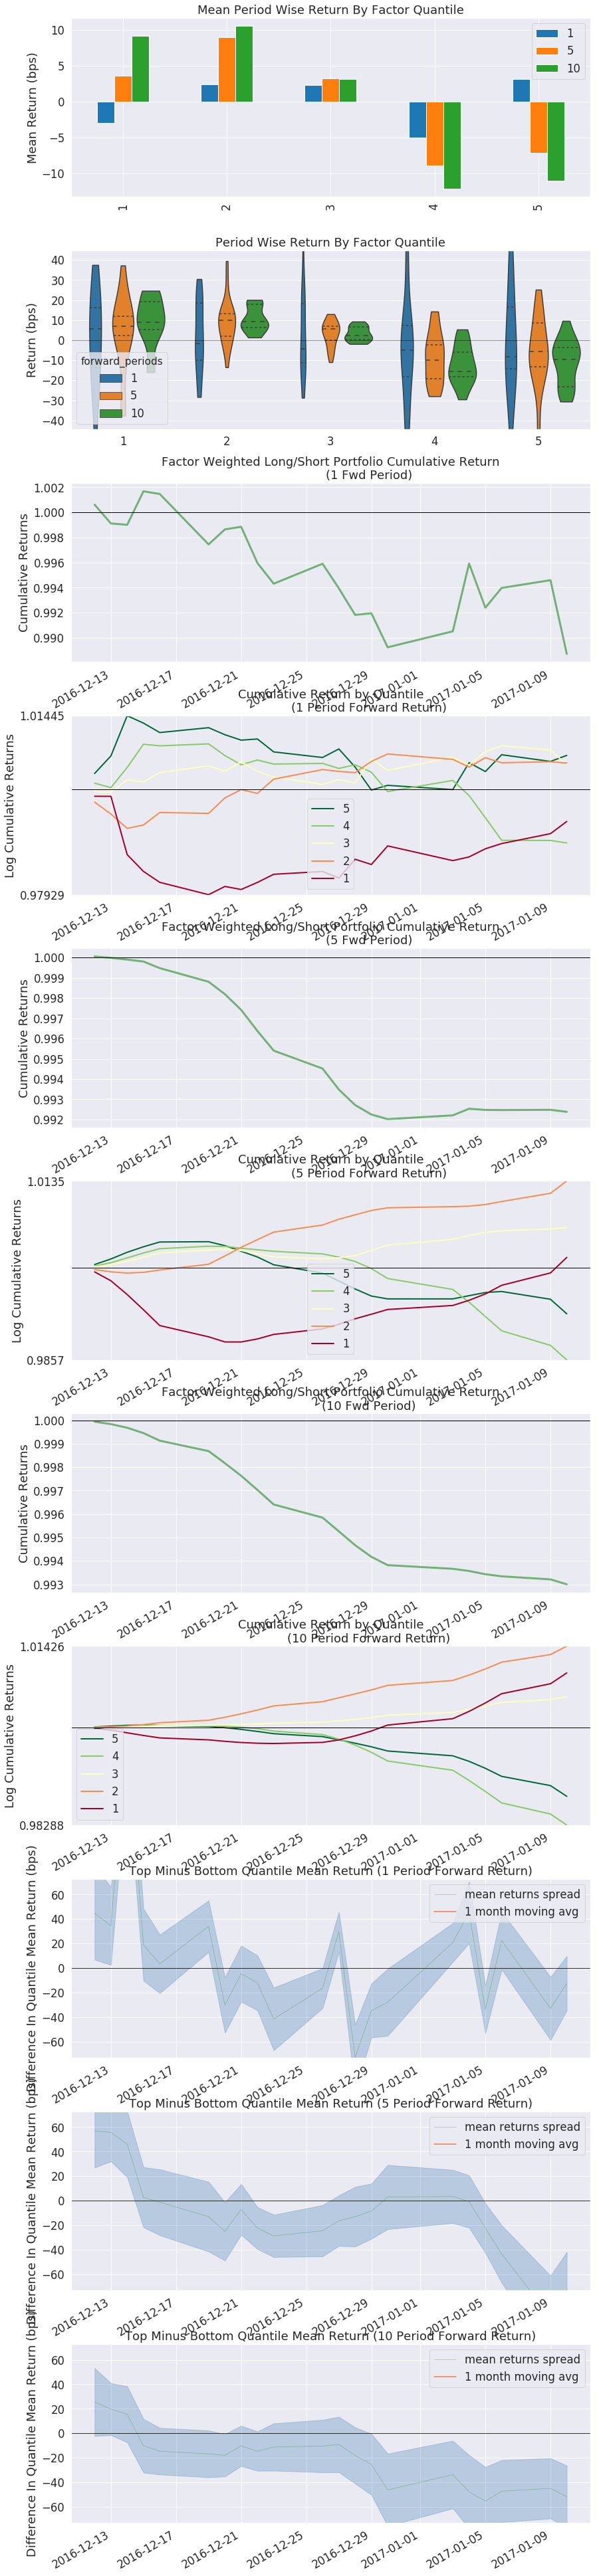

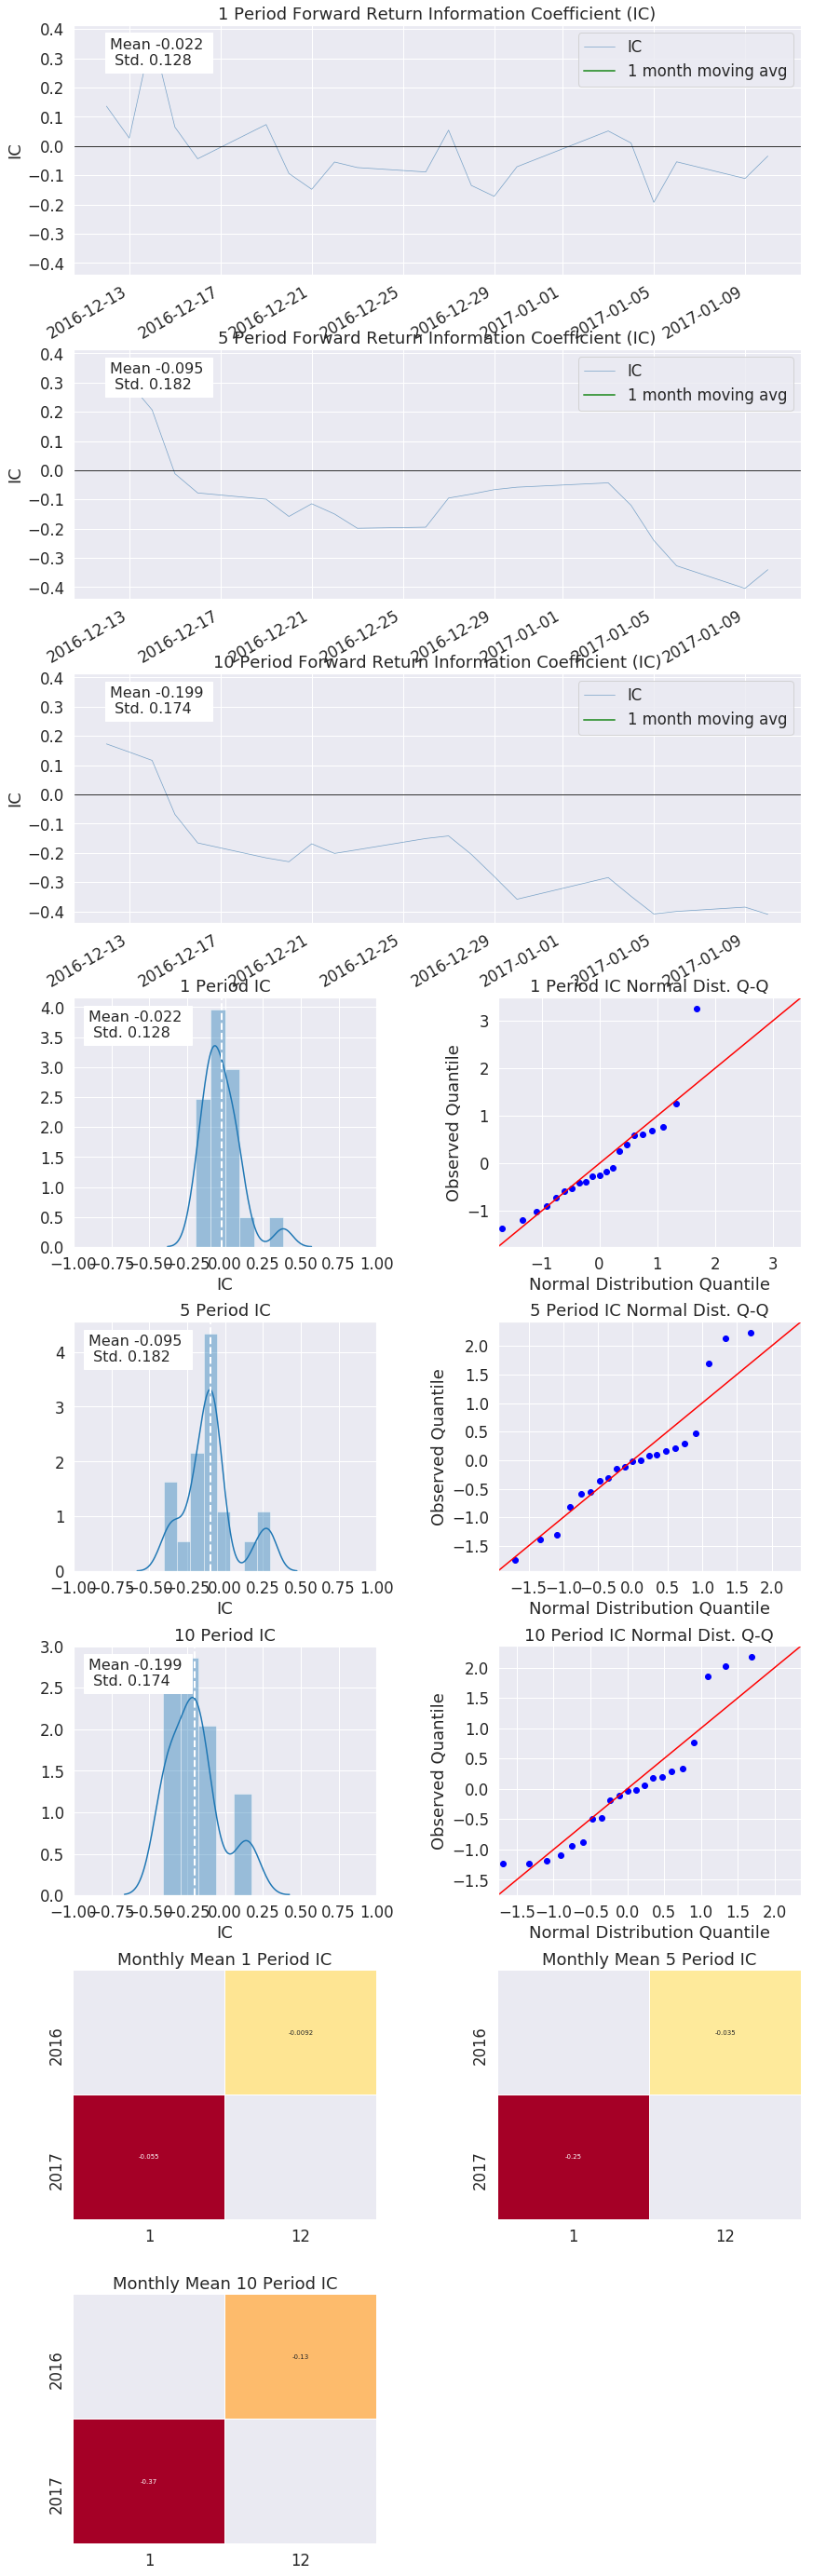

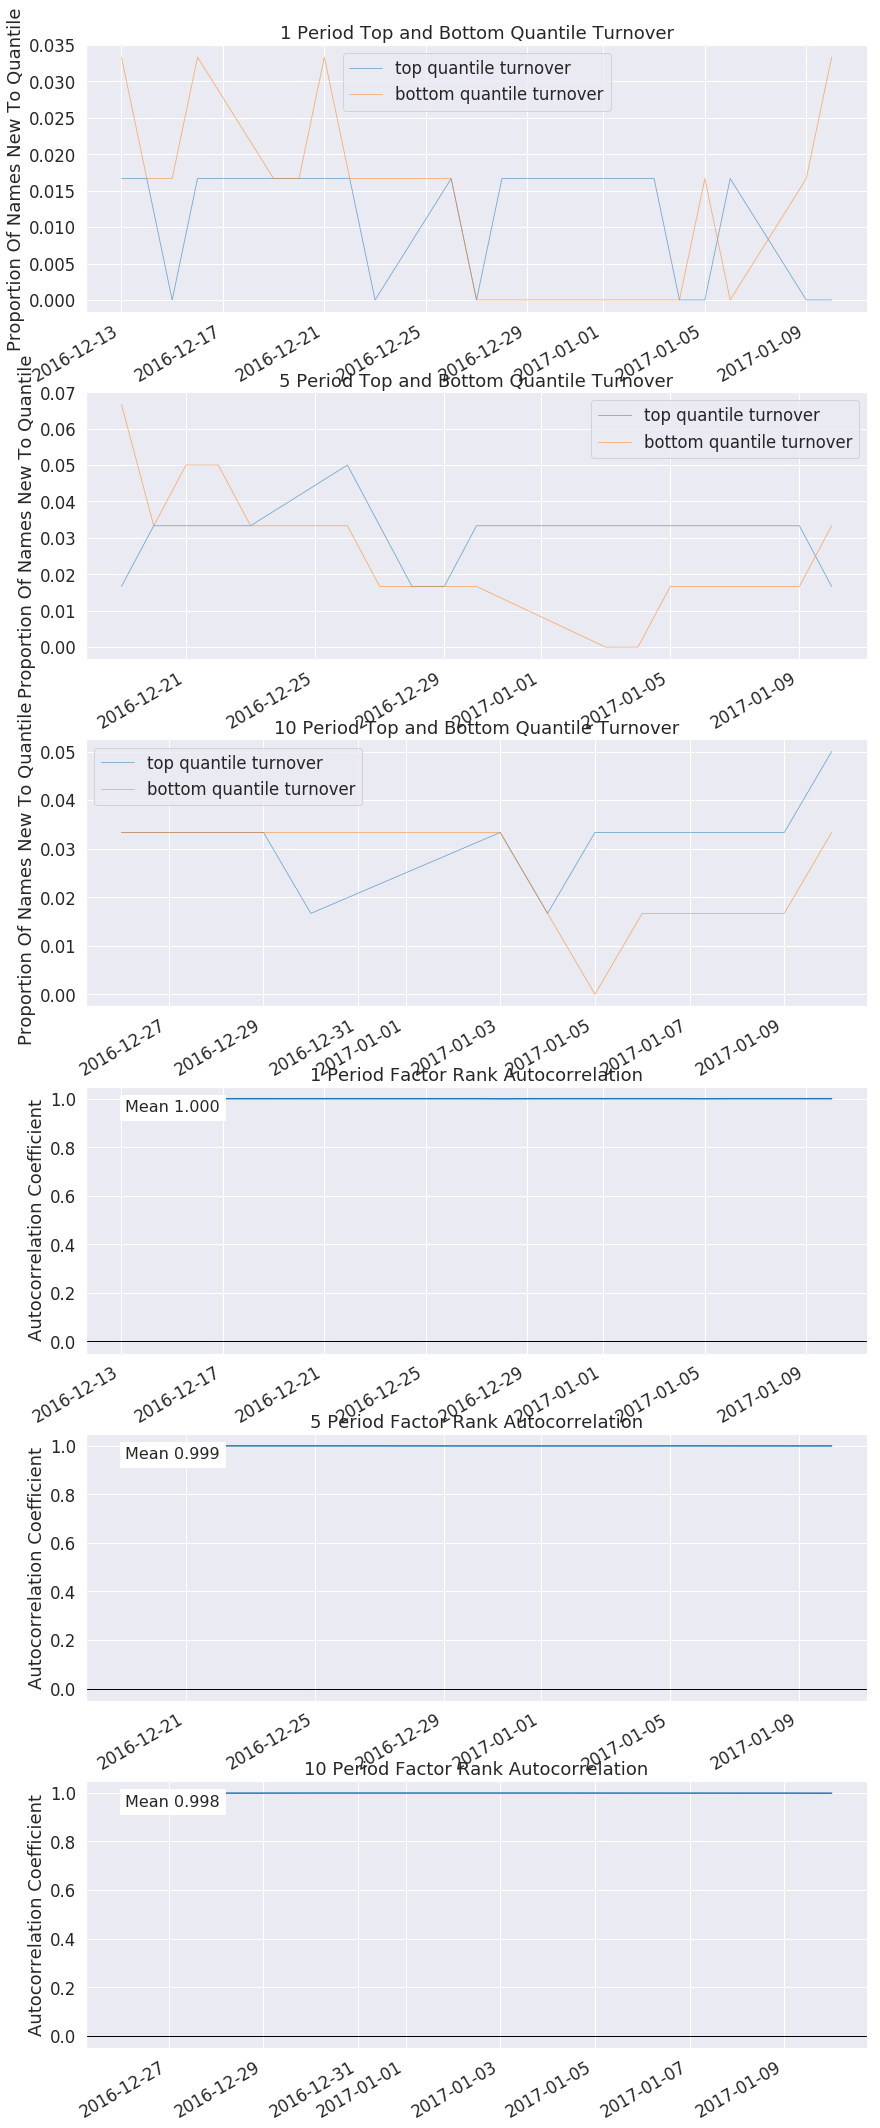

In [35]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(merged_data)

Information Analysis


,1,5,10
IC Mean,-0.022,-0.095,-0.199
IC Std.,0.128,0.182,0.174
Risk-Adjusted IC,-0.174,-0.522,-1.143
t-stat(IC),-0.799,-2.394,-5.238
p-value(IC),0.434,0.027,0.000
IC Skew,1.482,0.688,0.816
IC Kurtosis,2.910,0.325,-0.080


<Figure size 432x288 with 0 Axes>

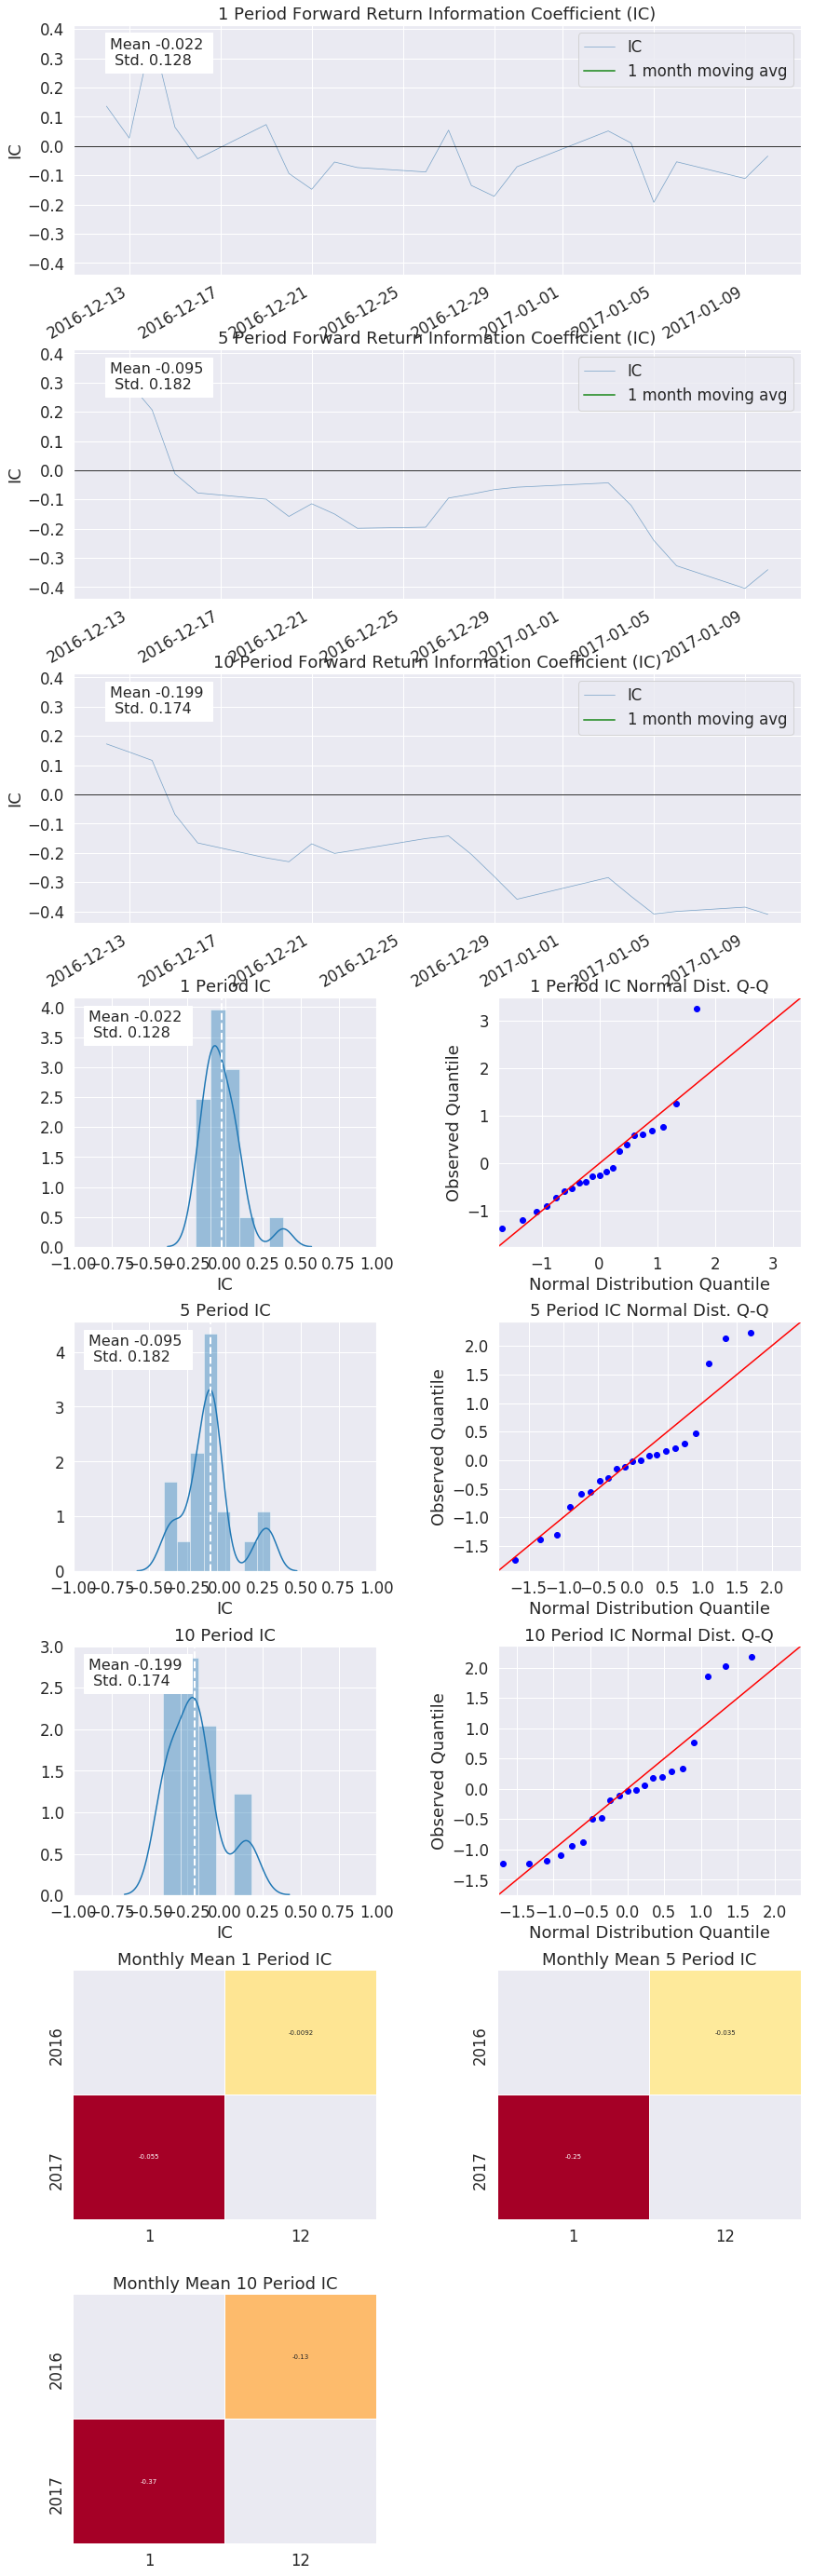

In [36]:
from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

create_information_tear_sheet(merged_data)

In [38]:
from alphalens.performance import mean_information_coefficient

IC_factor_data = get_clean_factor_and_forward_returns(
      factor=factor_data, 
      prices=price_data,
      periods=range(1,32,3)
)

mean_information_coefficient(IC_factor_data)
IC_factor_data

Dropped 0.0% entries from factor data (0.0% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


AttributeError: 'Series' object has no attribute 'columns'